This notebook is part of the $\omega radlib$  documentation: http://wradlib.org/wradlib-docs.

Copyright (c) 2016, $\omega radlib$  developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Match spaceborn PR (GPM/TRMM) with ground radars

The main objective is to compute the average reflectivity of high-resolution ground radar sweeps over TRMM/GPM PR bins. IDL code had been provided by Rob Warren based on Schwaller and Morris (2011). This notebook will provide a playground to port this to wradlib.

In [1]:
import wradlib as wradlib
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import datetime as dt
from osgeo import osr

Use magic `%pylab` to get separate image-windows

In [2]:
#%pylab

#### Writing functions that can be imported

In order to keep the notebook tidy and to avoid merge conflicts, you can put new functions in external Python module files and then import them into the notebook. Just put the Python files into the same directory as the notebook. Later, we can decide how to integrate these functions into wradlib modules. See the example module `external` with the function `hello_world` 

In [3]:
import external
external.hello_world()

Hello world.


#### Overview of available sample data for GPM, TRMM and matching ground radar

In [4]:
# define GPM data set
gpm_file = wradlib.util.get_wradlib_data_file('gpm/2A-RW-BRS.GPM.Ku.V6-20160118.20141206-S095002-E095137.004383.V04A.HDF5')

# define matching ground radar file
gr2gpm_file = wradlib.util.get_wradlib_data_file('hdf5/IDR66_20141206_094829.vol.h5')

# define TRMM data sets
trmm_2A23_file = wradlib.util.get_wradlib_data_file('trmm/2A-RW-BRS.TRMM.PR.2A23.20100206-S111422-E111519.069662.7.HDF')
trmm_2A25_file = wradlib.util.get_wradlib_data_file('trmm/2A-RW-BRS.TRMM.PR.2A25.20100206-S111422-E111519.069662.7.HDF')

# define matching ground radar file
gr2trmm_file = wradlib.util.get_wradlib_data_file('hdf5/IDR66_20100206_111233.vol.h5')

#### Read and organize the data

In [5]:
# read spaceborn PR data
import io_func
pr_data = io_func.read_gpm(gpm_file)
#pr_data = io_func.read_trmm(trmm_2A23_file, trmm_2A25_file)
# read matching GR data
gr_data = io_func.read_gr(gr2gpm_file)
#gr_data = wradlib.io.read_generic_hdf5(gr2trmm_file)

#### effective Earth Radius & Projections 

In [6]:
# calculate equivalent earth radius
wgs84 = wradlib.georef.get_default_projection()
lon0 = gr_data['lon']
lat0 = gr_data['lat']
alt0 = gr_data['alt']
re1 = wradlib.georef.get_earth_radius(lat0, wgs84) * 4./3.
print("eff. Earth radius 1:", re1)
a = wgs84.GetSemiMajor()
b = wgs84.GetSemiMinor()
print("SemiMajor, SemiMinor:", a, b)


# setup aeqd-projection gr-centered
rad = wradlib.georef.proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' + 
                                   '+lat_0={lat:f} +a={a:f} ' +
                                   '+b={b:f}').format(lon=lon0,
                                                       lat=lat0,
                                                       a=a, b=b))
re2 = wradlib.georef.get_earth_radius(lat0, rad) * 4./3.
print("eff. Earth radius 2:", re2)

('eff. Earth radius 1:', 8498054.7197525594)
('SemiMajor, SemiMinor:', 6378137.0, 6356752.314245179)
('eff. Earth radius 2:', 8498054.7197525073)


#### Creation of GR-Grids

In [7]:
# create gr range and azimuth arrays
rmax = gr_data['r0'] + gr_data['ngate'] * gr_data['dr']
rng = np.arange(0, gr_data['ngate'][0]) * gr_data['dr'][0] + gr_data['dr'][0]/2.
azi = np.arange(0, gr_data['nbeam'][0]) - gr_data['a0'][0]
print("Range/Azi-Shape:", rng.shape, azi.shape)

# create gr lonlat grid
# use lowest elevation (first in this case)
el = gr_data['elang'][0]
gr_grid = np.meshgrid(rng, azi)
rlon, rlat, ralt = wradlib.georef.polar2lonlatalt_n(gr_grid[0], gr_grid[1], el, (lon0, lat0, alt0 ))
gr_ll = np.dstack((rlon, rlat, ralt))
print("LonLatAlt-Grid-Shape", gr_ll.shape)

# reproject to xyz
gr_xy = wradlib.georef.reproject(gr_ll, projection_source=wgs84, projection_target=rad)
print("XYZ-Grid-Shape:", gr_xy.shape)

# get radar domain (outer ring)
gr_domain = gr_xy[:,-1,0:2]
gr_domain = np.vstack((gr_domain, gr_domain[0]))
print("Domain-Shape:", gr_domain.shape)

('Range/Azi-Shape:', (600,), (360,))
('LonLatAlt-Grid-Shape', (360, 600, 3))
('XYZ-Grid-Shape:', (360, 600, 3))
('Domain-Shape:', (361, 2))


#### Creation of PR-Grids

('PR-GRID-Shapes:', (137, 49), (137, 49), (137, 49, 2))


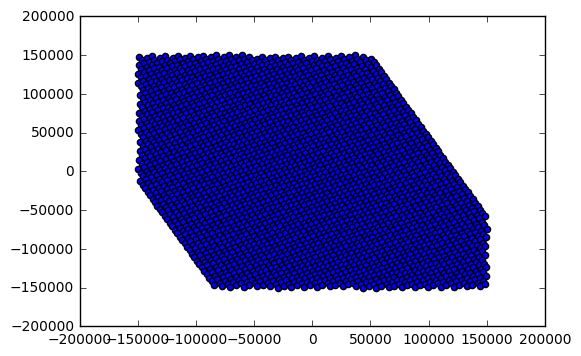

In [8]:
lonp = pr_data['lon']
latp = pr_data['lat']
pr_x, pr_y = wradlib.georef.reproject(lonp, latp, 
                                      projection_source=wgs84, 
                                      projection_target=rad)
pr_xy = np.dstack((pr_x, pr_y))
print("PR-GRID-Shapes:", pr_x.shape, pr_y.shape, pr_xy.shape)

# get boolean array of pr-bins within gr-array
# crude method box-based
iover = ((pr_x >= -rmax[0]) & (pr_x <= rmax[0]) & 
         (pr_y >= -rmax[0]) & (pr_y <= rmax[0]))

pl.scatter(pr_x[iover], pr_y[iover])

#### Creating ZonalDataPoint

In [9]:
l_gr = []
l_gr.append(gr_domain)
zd = wradlib.zonalstats.ZonalDataPoint(pr_xy.reshape(-1, pr_xy.shape[-1]), l_gr, srs=rad, buf=500.)
obj1 = wradlib.zonalstats.GridPointsToPoly(zd)

Calculate Intersection source/target-layers


#### Get precipitating PR-Bins

In [10]:
# get source indices within GR-Domain from zonal object
# 0 because we have only one zone
pr_idx = obj1.zdata.get_source_index(0) 

# get precip flag from pr_data
pflag = pr_data['pflag']

# create src_idx
src_idx = np.zeros_like(pflag, dtype=np.bool)
mask = np.unravel_index(pr_idx, pflag.shape)
src_idx[mask] = True

# get precip indexes
precip_mask = (pflag == 2)
precip_idx = src_idx & precip_mask

# get iscan/iray boolean arrays
iscan = precip_idx.nonzero()[0]
iray = precip_idx.nonzero()[1]

#### Plot PR-Swath Points vs. GR-Domain and Precip

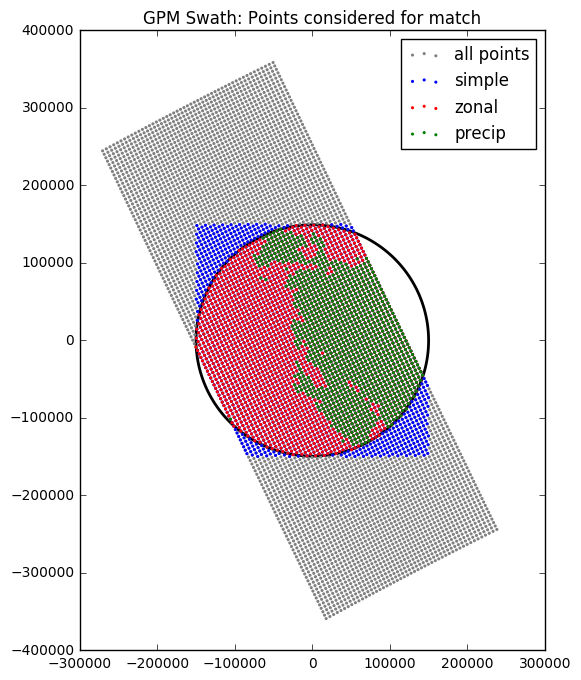

In [12]:
i = 0  
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, aspect="equal")

# Target polygon patches
trg_patches = [patches.Polygon(item, True) for item in obj1.zdata.trg.data]
trg_patch = [trg_patches[0]]
p = PatchCollection(trg_patch, facecolor="None", edgecolor="black",
                    linewidth=2)
ax.add_collection(p)

# pips
sources = obj1.zdata.src.data
isecs = obj1.zdata.isecs

pl.scatter(sources[:, 0], sources[:, 1], s=5, c='grey',
            edgecolor="None", label="all points")
pl.scatter(pr_x[iover], pr_y[iover], s=5, c='blue',
          edgecolor="None", label="simple")
pl.scatter(isecs[i][:, 0], isecs[i][:, 1], s=5, c='red',
            edgecolor="None", label="zonal")
pl.scatter(pr_x[precip_idx], pr_y[precip_idx], s=5, c='green',
          edgecolor="None", label="precip")

pl.legend()
pl.title("GPM Swath: Points considered for match")

#### PR Parallax Correction

In [13]:
def correct_parallax(pr_xy, nray, nbin, drt, alpha):

    # get x,y-grids
    pr_x = pr_xy[...,0]
    pr_y = pr_xy[...,1]
    
    # create range array from ground to sat
    prng = np.arange(nbin) * drt
    print("PRANGE:", prng.shape, prng.max())

    # calculate height of bin
    zp = prng * np.cos(np.deg2rad(alpha))[:,np.newaxis]
    # calculate bin ground xy-displacement length
    ds = prng * np.sin(np.deg2rad(alpha))[:, np.newaxis]
    print("HEIGHT:", zp.shape, zp.max())

    # calculate x,y-differences between ground coordinate 
    # and center ground coordinate [25th element]
    xdiff = pr_x[:,24][:, np.newaxis] - pr_x 
    ydiff = pr_y[:,24][:, np.newaxis] - pr_y 
    print("XDIFF:", xdiff.shape)

    # assuming ydiff and xdiff being a triangles adjacent and 
    # opposite this calculates the xy-angle of the PR scan
    ang = np.arctan2(ydiff, xdiff)
    print("Ang:", ang.shape)

    # calculate displacement dx, dy from displacement length
    dx = ds * np.cos(ang)[...,np.newaxis]
    dy = ds * np.sin(ang)[...,np.newaxis]
    print("DX:", dx.shape)

    # add displacement to PR ground coordinates
    pr_xp = dx + pr_x[..., np.newaxis]
    pr_yp = dy + pr_y[..., np.newaxis]
    print("XP:", pr_xp.shape)
    
    return np.stack((pr_xp, pr_yp, np.repeat(zp[np.newaxis,...],pr_xp.shape[0], axis=0)), axis=3), prng, zp

#### Plot Parallax corrected Views

('NRAY', 49)
('NBIN', 176)
('PRANGE:', (176,), 21875.0)
('HEIGHT:', (49, 176), 21875.0)
('XDIFF:', (137, 49))
('Ang:', (137, 49))
('DX:', (137, 49, 176))
('XP:', (137, 49, 176))
('PR_XYP:', (137, 49, 176, 3), (49, 176))


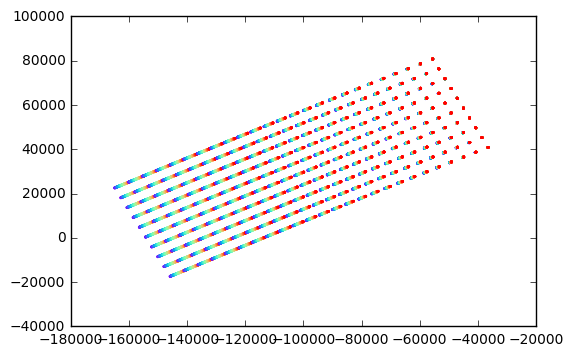

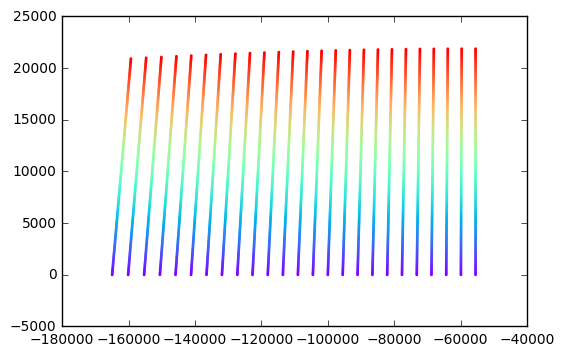

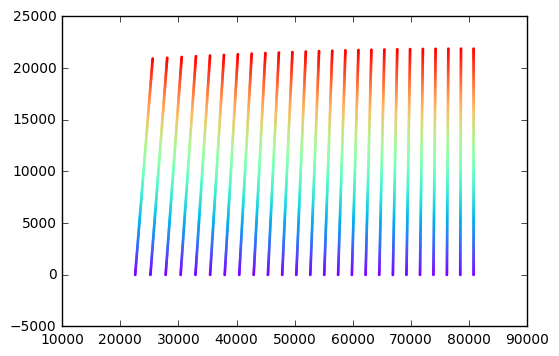

In [14]:
drt = 125.
nray = pr_data['nray']
nbin = pr_data['nbin']
print("NRAY", nray)
print("NBIN", nbin)

# approximation
alpha = abs(-17.04 + np.arange(nray) * 0.71)

# correct parallax, get 3D-XYZ-Array
pr_xyp, prng, zp = correct_parallax(pr_xy, nray, nbin, drt, alpha)

print("PR_XYP:", pr_xyp.shape, zp.shape)

colors = cm.rainbow(np.linspace(0, 1, 176))
pl.figure()
pl.scatter(pr_xyp[50:60,0:25,:,0], pr_xyp[50:60,0:25,:,1], s=1, c=colors, edgecolors=colors)
pl.figure()
pl.scatter(pr_xyp[50,0:25,:,0], zp[0:25,:], s=1, c=colors, edgecolors=colors)
pl.figure()
pl.scatter(pr_xyp[50,0:25,:,1], zp[0:25,:], s=1, c=colors, edgecolors=colors)

#### Transfer PR Coordinates to GR Polar Coordinates 

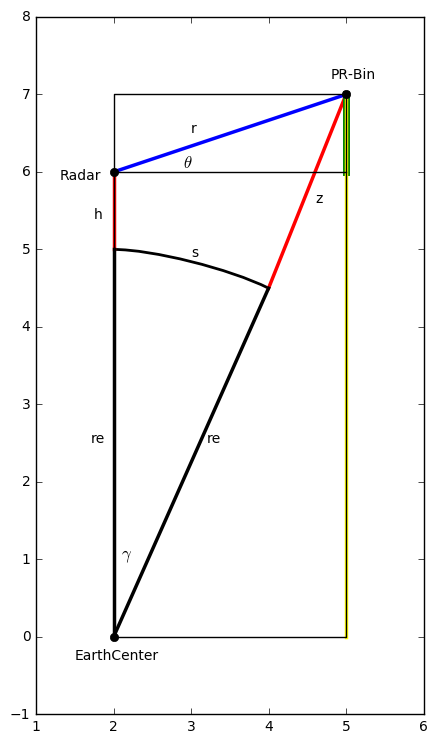

In [18]:
# Create Image of GR/PR-Setup
fig, ax = pl.subplots(figsize=(5,10))
lines = []

lines.append(pl.Line2D((2, 5), (6, 7), 
                       lw=2.5, c='blue', 
                       ms=12, label='Slant Range'))
lines.append(pl.Line2D((2, 2), (5, 6), 
                       lw=2.5, c='red', 
                       ms=12, label='Radar Height'))
lines.append(pl.Line2D((2, 2), (0, 5), 
                       lw=2.5, c='black', 
                       ms=12, label='earth radius at radar site'))
lines.append(pl.Line2D((4, 5), (4.5, 7), 
                       lw=2.5, c='red', 
                       ms=12, label='PR-Bin height'))
lines.append(pl.Line2D((2, 4), (0, 4.5), 
                       lw=2.5, c='black', 
                       ms=12, label='earth radius at PR-Bin'))           
lines.append(pl.Line2D((5, 5), (7, 6), 
                       lw=5., c='green', ms=12, 
                       label='Line 1'))             
lines.append(pl.Line2D((5, 5), (7, 0), 
                       lw=2.5, c='yellow', 
                       ms=12, label='Line 2'))
lines.append(pl.Line2D((2, 2, 5, 5, 2), (0, 7, 7, 0, 0), 
                       lw=1., c='black', 
                       ms=5, label='Box 1'))
lines.append(pl.Line2D((2, 5), (6, 6), 
                       lw=1., c='black', 
                       ms=5, label='Box 2'))
for line in lines:
    ax.add_line(line)

# s circle
verts = [
    (2., 5.),  # P0
    (2.5, 5.), # P1
    (3.5, 4.75), # P2
    (4., 4.5), # P3
    ]

codes = [Path.MOVETO,
         Path.CURVE4,
         Path.CURVE4,
         Path.CURVE4,
         ]

path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='none', lw=2)
ax.add_patch(patch)

# triangle 
ax.text(1.75, 5.4, 'h')
ax.text(4.6, 5.6, 'z')
ax.text(3.2, 2.5, 're')
ax.text(1.7, 2.5, 're')
ax.text(3, 6.5, 'r')
ax.text(3, 4.9, 's')

# angles
ax.text(2.9, 6.05, r'$\theta$', size='large')
ax.text(2.1, 1., r'$\gamma$', size='large')

# markers
ax.plot(2,0, 'ko')
ax.text(1.5, -0.3, 'EarthCenter')
ax.plot(2,6, 'ko')
ax.text(1.3, 5.9, 'Radar')
ax.plot(5,7, 'ko')
ax.text(4.8, 7.2, 'PR-Bin')

# limits
ax.set_xlim(1,6)
ax.set_ylim(-1,8)
ax.set_aspect('equal')

#### Calculate R/Theta/Phi

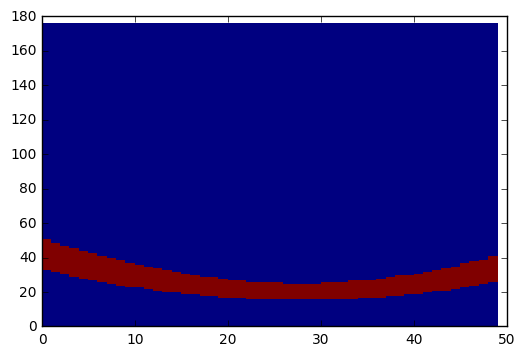

In [20]:
def sat2pol(prcoords, grcoords, re):
    
    # calculate arc length
    s = np.sqrt(np.sum(prcoords[...,0:2]**2, axis=-1))
    
    # calculate arc angle
    gamma = s / re
    
    # calculate theta (elevation-angle)
    numer = np.cos(gamma) - (re+grcoords[2])/(re+prcoords[...,2])
    denom = np.sin(gamma)
    theta = np.rad2deg(np.arctan(numer/denom))
    
    # calculate SlantRange r
    r = (re+prcoords[...,2])*denom/np.cos(np.deg2rad(theta))
    
    # calculate Azimuth phi
    phi = 90 - np.rad2deg(np.arctan2(prcoords[..., 1], prcoords[..., 0]))
    phi[phi <= 0] += 360
    
    return r, theta, phi
    
bwt = 0.71    
rs, thetas, phis = sat2pol(pr_xyp, (lon0, lat0, alt0), re1)    
mask = (thetas > (1.0 - bwt/2)) & (thetas < (1.0 + bwt/2))
pl.figure()
pl.pcolormesh(mask[90,:,:].T)

#### Pulse Volume of a cone frustum

$V=(\pi/3) \cdot h \cdot (R^2 + R \cdot r + r^2)$

$R=r= \tan ( \theta \cdot \pi/180 ) \cdot range$

$V=\pi \cdot h \cdot range^2 \cdot \tan(\theta \cdot \pi/180)^2$

Volume calculation according IDL-code

$V=1e^{-9} \cdot \pi \cdot (\frac{oh}{\cos(\alpha)} \cdot \frac{bwt}{2})^2 \cdot drt$

(-2.7318901501402064, -2.2360666120768466)


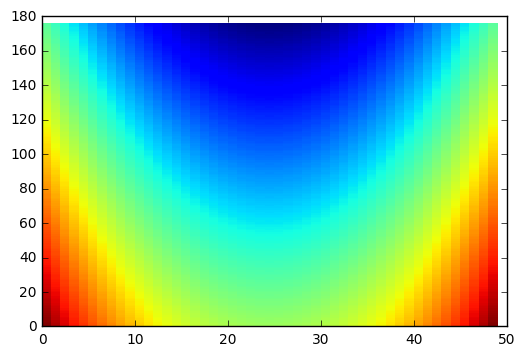

In [22]:
def pulse_volume(orbit_height, prng, alpha, bwt):
    rt = orbit_height/np.cos(np.deg2rad(alpha))[:, np.newaxis] - prng
    vol = 1e-9*np.pi*(rt*np.deg2rad(bwt/2.)**2*prng[1])
    return vol

zt=407000.

# PV according IDL-Code
pv1 = pulse_volume(zt, prng, alpha, 0.71)
pl.pcolor(pv1.T)
rt = zt/np.cos(np.deg2rad(alpha))[:, np.newaxis] - prng

# PV according wradlib function
pv2 = 1e-9*np.pi * prng[1] * (rt ** 2) * (np.tan(np.radians(0.71/2.))) ** 2

# print min/max difference
print((pv1-pv2).min(), (pv1-pv2).max())

#### Median Brightband Width/Height

('ZBB', (137, 49), -1111.1, 4814.7271)
('BBWidth', (137, 49), -1111.1, 1340.8645)
('MEDIAN:', 3855.8948, 747.69403)
('ZMLT:', (137, 49))
('RATIO:', (137, 49, 176))


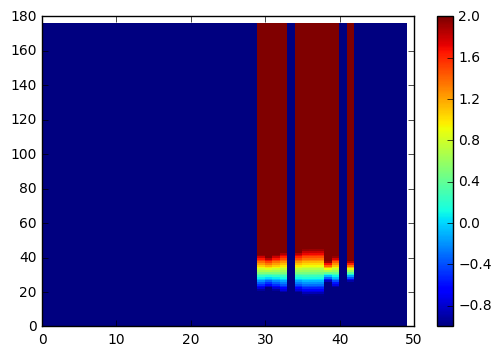

In [24]:
def get_bb_ratio(pr_data):

    zbb = pr_data['zbb']
    bbwidth = pr_data['bbwidth']
    quality = pr_data['quality']
    print("ZBB", zbb.shape, np.nanmin(zbb), np.nanmax(zbb))
    print("BBWidth", bbwidth.shape, np.nanmin(bbwidth), np.nanmax(bbwidth))

    # parameters for bb detection
    ibb = (zbb > 0) & (bbwidth > 0) & (quality == 1)
    
    # set non-bb-pixels to np.nan
    zbb[~ibb] = np.nan 
    bbwidth[~ibb] = np.nan 
    
    # get median of bb-pixels
    zbb_m = np.nanmedian(zbb)
    bbwidth_m = np.nanmedian(bbwidth)
    print("MEDIAN:", zbb_m, bbwidth_m)
    
    # approximation of melting layer top and bottom
    zmlt=zbb_m+bbwidth/2.
    zmlb=zbb_m-bbwidth/2.
    print("ZMLT:", zmlt.shape)

    # get ratio connected to brightband height
    # ratio <= 0: below ml
    # 0 < ratio < 1 : between ml
    # 1 <= ratio: above ml
    ratio = (zp - zmlb[:, :, np.newaxis]) / (zmlt - zmlb)[:, :, np.newaxis]
    print("RATIO:", ratio.shape)
    
    return ratio

pr_data = io_func.read_gpm(gpm_file)
ratio = get_bb_ratio(pr_data)
pl.figure()
pl.pcolormesh(ratio[60,:,:].T, vmin=-1, vmax=2)
pl.colorbar()

#### Convert Ku to S-band using Cao et.al. and S to Ku using Liao and Meneghini

('REFP:', (137, 49, 176))


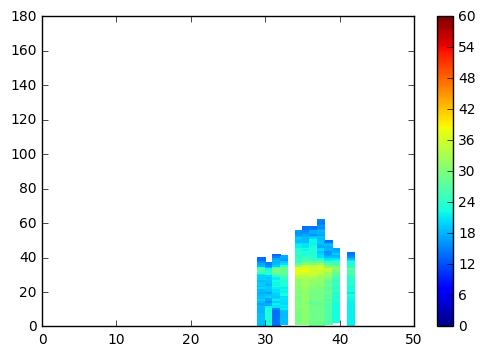

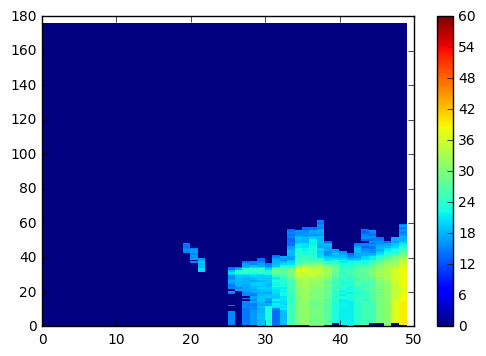

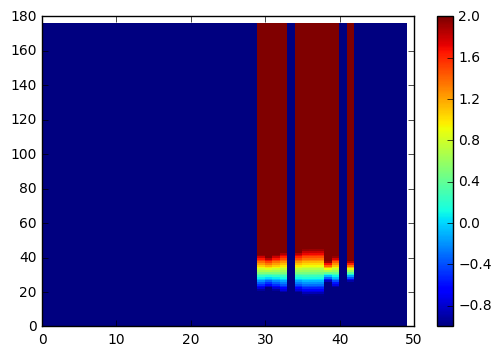

In [25]:
def calculate_polynomial(data, w):
    #print("Data:", data.shape, w.shape)
    res = np.zeros_like(data)
    for i, c in enumerate(w):
        #print(i, res.shape, c.shape, (data**i).shape)
        res += c * data**i
    #print(w.shape)
    #res1 = (w[0] +
    #        w[1] * data +            
    #        w[2] * data**2 +
    #        w[3] * data**3 +
    #        w[4] * data**4)
    #print(res1 - res)
    return res

def ku_s_coefficients():
    
    cs = np.array([0.185074, 1.01378, 0.00189212])
    cr = np.array([-1.50393, 1.07274, 0.000165393])
    
    return cs, cr
    

def s_ku_coefficients():
    
    # Set coefficients for conversion from Ku-band to S-band
    
    # Snow
    #        Rain      90%      80%      70%      60%      50%      40%      30%      20%      10%     Snow
    as0=[4.78e-2, 4.12e-2, 8.12e-2, 1.59e-1, 2.87e-1, 4.93e-1, 8.16e-1, 1.31e+0, 2.01e+0, 2.82e+0, 1.74e-1]
    as1=[ 1.23e-2, 3.66e-3, 2.00e-3, 9.42e-4, 5.29e-4, 5.96e-4, 1.22e-3, 2.11e-3, 3.34e-3, 5.33e-3, 1.35e-2]
    as2=[-3.50e-4, 1.17e-3, 1.04e-3, 8.16e-4, 6.59e-4, 5.85e-4, 6.13e-4, 7.01e-4, 8.24e-4, 1.01e-3,-1.38e-3]
    as3=[-3.30e-5,-8.08e-5,-6.44e-5,-4.97e-5,-4.15e-5,-3.89e-5,-4.15e-5,-4.58e-5,-5.06e-5,-5.78e-5, 4.74e-5]
    as4=[ 4.27e-7, 9.25e-7,7.41e-7, 6.13e-7, 5.80e-7, 6.16e-7, 7.12e-7, 8.22e-7, 9.39e-7, 1.10e-6, 0.00e+0]

    a_s = np.array([as0, as1, as2, as3, as4])
    
    # Hail
    #        Rain      90%      80%      70%      60%      50%      40%      30%      20%      10%     Hail
    ah0=[ 4.78e-2, 1.80e-1, 1.95e-1, 1.88e-1, 2.36e-1, 2.70e-1, 2.98e-1, 2.85e-1, 1.75e-1, 4.30e-2, 8.80e-2]
    ah1=[ 1.23e-2,-3.73e-2,-3.83e-2,-3.29e-2,-3.46e-2,-2.94e-2,-2.10e-2,-9.96e-3,-8.05e-3,-8.27e-3, 5.39e-2]
    ah2=[-3.50e-4, 4.08e-3, 4.14e-3, 3.75e-3, 3.71e-3, 3.22e-3, 2.44e-3, 1.45e-3, 1.21e-3, 1.66e-3,-2.99e-4]
    ah3=[-3.30e-5,-1.59e-4,-1.54e-4,-1.39e-4,-1.30e-4,-1.12e-4,-8.56e-5,-5.33e-5,-4.66e-5,-7.19e-5, 1.90e-5]
    ah4=[ 4.27e-7, 1.59e-6, 1.51e-6, 1.37e-6, 1.29e-6, 1.15e-6, 9.40e-7, 6.71e-7, 6.33e-7, 9.52e-7, 0.00e+0]

    a_h = np.array([ah0, ah1, ah2, ah3, ah4])#.T

    return a_s, a_h

def fix_for_cband(refp, refp_ss, refp_sh):
    delta_s = (refp_ss - refp) * 5.3 / 10.0
    refp_ss = refp + deltas
    delta_h = (refp_sh - refp) * 5.3 / 10.0
    refp_sh = refp + deltah
    return refp_ss, refp_sh


# REVERSE!!!
refp = pr_data['refl'][:,:,::-1]
print("REFP:", refp.shape)

refp_ss = np.zeros_like(refp) * np.nan
refp_sh = np.zeros_like(refp) * np.nan

a_s, a_h = s_ku_coefficients()

ia = (ratio >= 1)
refp_ss[ia] = refp[ia] + calculate_polynomial(refp[ia], a_s[:,10])
refp_sh[ia] = refp[ia] + calculate_polynomial(refp[ia], a_h[:,10])
ib = (ratio <= 0)
refp_ss[ib] = refp[ib] + calculate_polynomial(refp[ib], a_s[:,0])
refp_sh[ib] = refp[ib] + calculate_polynomial(refp[ib], a_h[:,0])
im = (ratio > 0) & (ratio < 1)
ind = np.round(ratio[im] * 10).astype(np.int)
#print("W:", a_s[:,ind].shape)
refp_ss[im] = refp[im] + calculate_polynomial(refp[im], a_s[:,ind])
refp_sh[im] = refp[im] + calculate_polynomial(refp[im], a_h[:,ind])

refp_ss[refp < 0] = np.nan
out = np.ma.masked_invalid(refp_ss)
pl.figure()
pl.pcolormesh(out[60,:,:].T, vmin=0, vmax=60)
pl.colorbar()
pl.figure()
pl.pcolormesh(refp[60,:,:].T, vmin=0, vmax=60)
pl.colorbar()
pl.figure()
pl.pcolormesh(ratio[60,:,:].T, vmin=-1, vmax=2)
pl.colorbar()

#### Beginning with actual matching

In [26]:
gr_data = io_func.read_gr(gr2gpm_file)
print(gr_data.keys())
ngate = gr_data['ngate']
nbeam = gr_data['nbeam']
ntilt = gr_data['ntilt']
elang = gr_data['elang']
dr = gr_data['dr']
refg = gr_data['refl']
sdate = gr_data['sdate']
r0 = gr_data['r0']
a0 = gr_data['a0']

['elang', 'sdate', 'r0', 'source', 'nbeam', 'lon', 'ntilt', 'a0', 'ngate', 'refl', 'date', 'lat', 'alt', 'dr']


#### Dates+Times

In [27]:
midnight = dt.datetime.combine(sdate[0].date(), dt.time())
seconds = [d.seconds for d in sdate-midnight]
print(seconds)

[35309, 35342, 35371, 35398, 35420, 35437, 35454, 35471, 35488, 35505, 35522, 35540, 35558, 35576]
